In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

## Decision tree for binary classification for Post and Healthy

In [12]:
train = pd.read_csv('csv_files_harmonized/balanced_train.csv')
#test = pd.read_csv('csv_files_harmonized/test.csv')
val = pd.read_csv('csv_files_harmonized/val.csv')

In [13]:
train = train[train.group != 'baseline']
#test = test[test.group != 'baseline']
val = val[val.group != 'baseline']

In [14]:
train['group'] = train['group'].map({'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'post': 1, 'healthy': 2})
#test['group'] = test['group'].map({'post': 1, 'healthy': 2})

marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]

# since we have basline and post these have the same id, which we do not want 
train['id_split'] = train['id']
train.loc[train['group'] == 1, 'id_split'] = train.loc[train['group'] == 1, 'id'] + '_post'

val['id_split'] = val['id']
val.loc[val['group'] == 1, 'id_split'] = val.loc[val['group'] == 1, 'id'] + '_post'

train['id_numeric'], train_id_mapping = pd.factorize(train['id_split'])
val['id_numeric'], val_id_mapping = pd.factorize(val['id_split'])

marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)

In [15]:
X_train = train[marker_columns]
y_train = train['group']

X_val = val[marker_columns]
y_val = val['group']

In [16]:
decisiontree = DecisionTreeClassifier(random_state=123)

decisiontree.fit(X_train, y_train)

print('Train accuracy per cell:', decisiontree.score(X_train, y_train))
print('Validation accuracy per cell:', decisiontree.score(X_val, y_val))

Train accuracy per cell: 1.0
Validation accuracy per cell: 0.7296290948583661


In [17]:
y_pred_cell = decisiontree.predict(X_val)

val['group_pred'] = y_pred_cell

patient_predictions = val.groupby('id_numeric')['group_pred'].agg(lambda x: x.mode()[0]).reset_index()

y_val_patient = val.groupby('id_numeric')['group'].first().reset_index()
patient_predictions = patient_predictions.merge(y_val_patient, on='id_numeric')
patient_accuracy = accuracy_score(patient_predictions['group'], patient_predictions['group_pred'])
print('Patient val accuracy:', patient_accuracy)

Patient val accuracy: 1.0


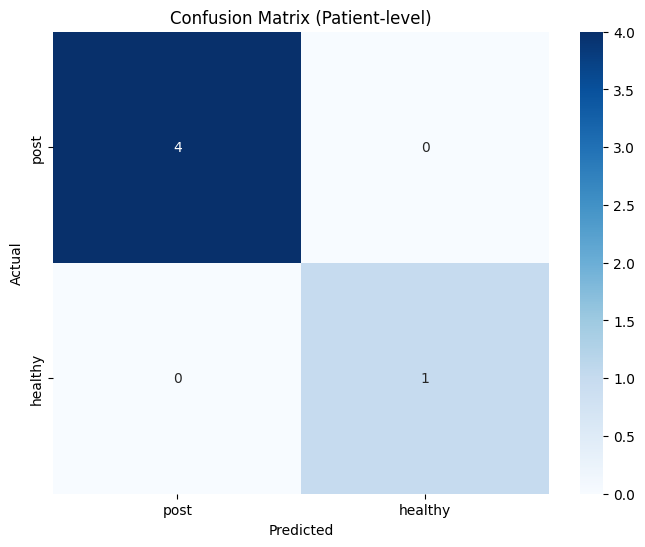

In [18]:
conf_matrix = confusion_matrix(patient_predictions['group'], patient_predictions['group_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['post', 'healthy'], yticklabels=['post', 'healthy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Patient-level)')
plt.show()

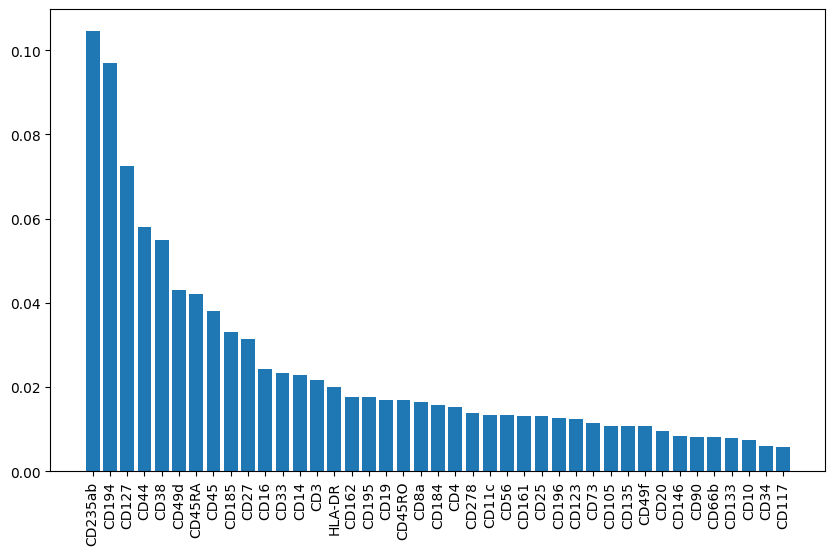

In [19]:
importance = decisiontree.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), [marker_columns[i] for i in indices], rotation=90)
plt.show()

In [20]:
print('The 5 most important features are:', [marker_columns[i] for i in indices[:5]])

The 5 most important features are: ['CD235ab', 'CD194', 'CD127', 'CD44', 'CD38']
